In [1]:
!pip install imantics --quiet


  Preparing metadata (setup.py) ... done


In [2]:
# -----------------------------------
# 1. Mount Google Drive
# -----------------------------------

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR        = '/content/drive/MyDrive/retina project/DRIVE_unzipped/DRIVE'
TRAIN_IMG_DIR   = f"{BASE_DIR}/training/images"
TRAIN_MASK_DIR  = f"{BASE_DIR}/training/1st_manual"
TEST_IMG_DIR    = f"{BASE_DIR}/test/images"
TEST_MASK_DIR   = f"{BASE_DIR}/test/1st_manual"


Mounted at /content/drive


In [3]:
# -----------------------------------
# 2. Imports & Params
# -----------------------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

IMG_SIZE   = 512
BATCH_SIZE = 4
EPOCHS     = 250

# CLAHE preprocessor (same as before)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def load_images(folder, file_pattern, is_mask=False):
    imgs = []
    for fname in sorted(os.listdir(folder)):
        if file_pattern not in fname: continue
        if not fname.lower().endswith(('.png','.tif','.jpg')): continue
        path = os.path.join(folder, fname)
        img  = cv2.imread(path, cv2.IMREAD_COLOR if not is_mask else cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Could not read {path}")
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        if not is_mask:
            g = img[:,:,1]
            g = clahe.apply(g)
            g = g.astype('float32')/255.0
            imgs.append(np.expand_dims(g, -1))
        else:
            m = img.astype('float32')/255.0
            imgs.append(np.expand_dims(m, -1))
    return np.array(imgs)

X_train = load_images(TRAIN_IMG_DIR, '_training.png', is_mask=False)
y_train = load_images(TRAIN_MASK_DIR,  '_manual1.png', is_mask=True)
X_test  = load_images(TEST_IMG_DIR,  '_test.png',    is_mask=False)
y_test  = load_images(TEST_MASK_DIR, '_manual1.png', is_mask=True)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [4]:
# -----------------------------------
# 3. Build U-Net³⁺ (static resizing)
# -----------------------------------
from tensorflow.keras import layers, models

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    return x

def resize_to(x, size):
    # size is a tuple (height, width)
    return layers.Resizing(size[0], size[1], interpolation='bilinear')(x)

def unet3plus(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = layers.Input(input_shape)
    # --- Encoder ---
    x0 = conv_block(inputs,  64)
    p0 = layers.MaxPool2D()(x0)

    x1 = conv_block(p0,     128)
    p1 = layers.MaxPool2D()(x1)

    x2 = conv_block(p1,     256)
    p2 = layers.MaxPool2D()(x2)

    x3 = conv_block(p2,     512)
    p3 = layers.MaxPool2D()(x3)

    x4 = conv_block(p3,    1024)

    # --- Decoder full-scale skip connections ---
    # Level 3 (1/8 = 64×64)
    d3 = layers.Concatenate()([
        resize_to(x4, (64, 64)),
        x3,
        resize_to(x2, (64, 64)),
        resize_to(x1, (64, 64)),
        resize_to(x0, (64, 64)),
    ])
    d3 = conv_block(d3, 512)

    # Level 2 (1/4 = 128×128)
    d2 = layers.Concatenate()([
        resize_to(x4, (128, 128)),
        resize_to(x3, (128, 128)),
        x2,
        resize_to(x1, (128, 128)),
        resize_to(x0, (128, 128)),
    ])
    d2 = conv_block(d2, 256)

    # Level 1 (1/2 = 256×256)
    d1 = layers.Concatenate()([
        resize_to(x4, (256, 256)),
        resize_to(x3, (256, 256)),
        resize_to(x2, (256, 256)),
        x1,
        resize_to(x0, (256, 256)),
    ])
    d1 = conv_block(d1, 128)

    # Level 0 (full = 512×512)
    d0 = layers.Concatenate()([
        resize_to(x4, (512, 512)),
        resize_to(x3, (512, 512)),
        resize_to(x2, (512, 512)),
        resize_to(x1, (512, 512)),
        x0,
    ])
    d0 = conv_block(d0, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(d0)
    return models.Model(inputs, outputs)

# Instantiate & compile
model = unet3plus(input_shape=(IMG_SIZE, IMG_SIZE, 1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │  1,180,160 │ max_pooling2d_2[

 Total params: 20,038,273 (76.44 MB)

 Trainable params: 20,030,081 (76.41 MB)

 Non-trainable params: 8,192 (32.00 KB)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define save path
checkpoint_path = "/content/drive/MyDrive/retina project/unet(3+)_best_model.h5"

# Define the callback to save best model
checkpoint_cb = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)


In [6]:
# -----------------------------------
# 4. Train
# -----------------------------------
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb],
    verbose=2
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 0.73117, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 67s - 17s/step - accuracy: 0.4868 - loss: 0.8463 - val_accuracy: 0.6295 - val_loss: 0.7312
Epoch 2/250

Epoch 2: val_loss did not improve from 0.73117
4/4 - 2s - 506ms/step - accuracy: 0.6086 - loss: 0.6558 - val_accuracy: 0.1217 - val_loss: 4.2404
Epoch 3/250

Epoch 3: val_loss did not improve from 0.73117
4/4 - 2s - 495ms/step - accuracy: 0.7704 - loss: 0.5963 - val_accuracy: 0.3102 - val_loss: 1.8817
Epoch 4/250

Epoch 4: val_loss did not improve from 0.73117
4/4 - 2s - 495ms/step - accuracy: 0.8184 - loss: 0.5558 - val_accuracy: 0.2873 - val_loss: 2.0409
Epoch 5/250

Epoch 5: val_loss did not improve from 0.73117
4/4 - 2s - 495ms/step - accuracy: 0.8464 - loss: 0.5189 - val_accuracy: 0.2347 - val_loss: 2.1350
Epoch 6/250

Epoch 6: val_loss did not improve from 0.73117
4/4 - 2s - 495ms/step - accuracy: 0.8668 - loss: 0.4895 - val_accuracy: 0.3776 - val_loss: 0.7433
Epoch 7/250

Epoch 7: val_loss improved from 0.73117 to 0.38218, saving model to /content/drive/MyDrive/retina pr

4/4 - 6s - 1s/step - accuracy: 0.8751 - loss: 0.4625 - val_accuracy: 0.8727 - val_loss: 0.3822
Epoch 8/250

Epoch 8: val_loss did not improve from 0.38218
4/4 - 2s - 504ms/step - accuracy: 0.8874 - loss: 0.4329 - val_accuracy: 0.8601 - val_loss: 0.4637
Epoch 9/250

Epoch 9: val_loss did not improve from 0.38218
4/4 - 2s - 495ms/step - accuracy: 0.8924 - loss: 0.4118 - val_accuracy: 0.8746 - val_loss: 0.3827
Epoch 10/250

Epoch 10: val_loss improved from 0.38218 to 0.36324, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 680ms/step - accuracy: 0.8914 - loss: 0.4040 - val_accuracy: 0.8736 - val_loss: 0.3632
Epoch 11/250

Epoch 11: val_loss did not improve from 0.36324
4/4 - 2s - 495ms/step - accuracy: 0.9033 - loss: 0.3758 - val_accuracy: 0.4849 - val_loss: 0.8189
Epoch 12/250

Epoch 12: val_loss did not improve from 0.36324
4/4 - 2s - 495ms/step - accuracy: 0.9068 - loss: 0.3526 - val_accuracy: 0.3792 - val_loss: 0.8365
Epoch 13/250

Epoch 13: val_loss did not improve from 0.36324
4/4 - 2s - 496ms/step - accuracy: 0.9088 - loss: 0.3362 - val_accuracy: 0.1859 - val_loss: 1.8903
Epoch 14/250

Epoch 14: val_loss did not improve from 0.36324
4/4 - 2s - 494ms/step - accuracy: 0.9115 - loss: 0.3187 - val_accuracy: 0.1924 - val_loss: 1.1836
Epoch 15/250

Epoch 15: val_loss did not improve from 0.36324
4/4 - 2s - 495ms/step - accuracy: 0.9139 - loss: 0.3059 - val_accuracy: 0.7137 - val_loss: 0.5537
Epoch 16/250

Epoch 16: val_loss did not improve from 0.36324
4/4 - 2s - 495ms/step - accuracy: 0.9159

4/4 - 3s - 688ms/step - accuracy: 0.9171 - loss: 0.2735 - val_accuracy: 0.8746 - val_loss: 0.3140
Epoch 19/250

Epoch 19: val_loss did not improve from 0.31396
4/4 - 2s - 495ms/step - accuracy: 0.9169 - loss: 0.2671 - val_accuracy: 0.8746 - val_loss: 0.3409
Epoch 20/250

Epoch 20: val_loss improved from 0.31396 to 0.29957, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 790ms/step - accuracy: 0.9180 - loss: 0.2560 - val_accuracy: 0.8746 - val_loss: 0.2996
Epoch 21/250

Epoch 21: val_loss did not improve from 0.29957
4/4 - 2s - 497ms/step - accuracy: 0.9182 - loss: 0.2448 - val_accuracy: 0.8746 - val_loss: 0.3053
Epoch 22/250

Epoch 22: val_loss did not improve from 0.29957
4/4 - 2s - 495ms/step - accuracy: 0.9195 - loss: 0.2365 - val_accuracy: 0.8746 - val_loss: 0.3805
Epoch 23/250

Epoch 23: val_loss did not improve from 0.29957
4/4 - 2s - 495ms/step - accuracy: 0.9204 - loss: 0.2281 - val_accuracy: 0.8746 - val_loss: 0.3102
Epoch 24/250

Epoch 24: val_loss did not improve from 0.29957
4/4 - 2s - 495ms/step - accuracy: 0.9194 - loss: 0.2203 - val_accuracy: 0.8746 - val_loss: 0.3101
Epoch 25/250

Epoch 25: val_loss did not improve from 0.29957
4/4 - 2s - 495ms/step - accuracy: 0.9210 - loss: 0.2118 - val_accuracy: 0.8746 - val_loss: 0.3151
Epoch 26/250

Epoch 26: val_loss did not improve from 0.29957
4/4 - 2s - 495ms/step - accuracy: 0.9209

4/4 - 3s - 751ms/step - accuracy: 0.9206 - loss: 0.1997 - val_accuracy: 0.8746 - val_loss: 0.2911
Epoch 28/250

Epoch 28: val_loss improved from 0.29107 to 0.28632, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 680ms/step - accuracy: 0.9200 - loss: 0.1967 - val_accuracy: 0.8746 - val_loss: 0.2863
Epoch 29/250

Epoch 29: val_loss did not improve from 0.28632
4/4 - 2s - 495ms/step - accuracy: 0.9213 - loss: 0.1899 - val_accuracy: 0.8746 - val_loss: 0.2974
Epoch 30/250

Epoch 30: val_loss did not improve from 0.28632
4/4 - 2s - 494ms/step - accuracy: 0.9203 - loss: 0.1891 - val_accuracy: 0.8746 - val_loss: 0.2978
Epoch 31/250

Epoch 31: val_loss did not improve from 0.28632
4/4 - 2s - 496ms/step - accuracy: 0.9215 - loss: 0.1786 - val_accuracy: 0.8746 - val_loss: 0.3086
Epoch 32/250

Epoch 32: val_loss did not improve from 0.28632
4/4 - 2s - 498ms/step - accuracy: 0.9202 - loss: 0.1779 - val_accuracy: 0.8746 - val_loss: 0.3166
Epoch 33/250

Epoch 33: val_loss did not improve from 0.28632
4/4 - 2s - 496ms/step - accuracy: 0.9216 - loss: 0.1716 - val_accuracy: 0.8746 - val_loss: 0.2995
Epoch 34/250

Epoch 34: val_loss did not improve from 0.28632
4/4 - 2s - 496ms/step - accuracy: 0.9217

4/4 - 5s - 1s/step - accuracy: 0.9252 - loss: 0.0917 - val_accuracy: 0.8841 - val_loss: 0.2751
Epoch 110/250

Epoch 110: val_loss improved from 0.27515 to 0.19580, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 694ms/step - accuracy: 0.9214 - loss: 0.1207 - val_accuracy: 0.8926 - val_loss: 0.1958
Epoch 111/250

Epoch 111: val_loss did not improve from 0.19580
4/4 - 2s - 495ms/step - accuracy: 0.9219 - loss: 0.1205 - val_accuracy: 0.3210 - val_loss: 5.7749
Epoch 112/250

Epoch 112: val_loss did not improve from 0.19580
4/4 - 2s - 495ms/step - accuracy: 0.9215 - loss: 0.1127 - val_accuracy: 0.3211 - val_loss: 11.3330
Epoch 113/250

Epoch 113: val_loss did not improve from 0.19580
4/4 - 2s - 495ms/step - accuracy: 0.9219 - loss: 0.1092 - val_accuracy: 0.2660 - val_loss: 18.6334
Epoch 114/250

Epoch 114: val_loss did not improve from 0.19580
4/4 - 2s - 495ms/step - accuracy: 0.9223 - loss: 0.1059 - val_accuracy: 0.1326 - val_loss: 15.8583
Epoch 115/250

Epoch 115: val_loss did not improve from 0.19580
4/4 - 2s - 500ms/step - accuracy: 0.9231 - loss: 0.1036 - val_accuracy: 0.1096 - val_loss: 11.1374
Epoch 116/250

Epoch 116: val_loss did not improve from 0.19580
4/4 - 2s - 496ms/step - 

4/4 - 5s - 1s/step - accuracy: 0.9259 - loss: 0.0897 - val_accuracy: 0.8941 - val_loss: 0.1941
Epoch 125/250

Epoch 125: val_loss improved from 0.19413 to 0.16686, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 693ms/step - accuracy: 0.9260 - loss: 0.0899 - val_accuracy: 0.9038 - val_loss: 0.1669
Epoch 126/250

Epoch 126: val_loss did not improve from 0.16686
4/4 - 2s - 496ms/step - accuracy: 0.9257 - loss: 0.0900 - val_accuracy: 0.8819 - val_loss: 0.2363
Epoch 127/250

Epoch 127: val_loss improved from 0.16686 to 0.16032, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 677ms/step - accuracy: 0.9262 - loss: 0.0878 - val_accuracy: 0.9037 - val_loss: 0.1603
Epoch 128/250

Epoch 128: val_loss did not improve from 0.16032
4/4 - 2s - 496ms/step - accuracy: 0.9265 - loss: 0.0873 - val_accuracy: 0.9029 - val_loss: 0.1622
Epoch 129/250

Epoch 129: val_loss did not improve from 0.16032
4/4 - 2s - 495ms/step - accuracy: 0.9266 - loss: 0.0860 - val_accuracy: 0.9008 - val_loss: 0.1675
Epoch 130/250

Epoch 130: val_loss improved from 0.16032 to 0.15273, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 683ms/step - accuracy: 0.9268 - loss: 0.0854 - val_accuracy: 0.9071 - val_loss: 0.1527
Epoch 131/250

Epoch 131: val_loss did not improve from 0.15273
4/4 - 2s - 498ms/step - accuracy: 0.9272 - loss: 0.0835 - val_accuracy: 0.9080 - val_loss: 0.1652
Epoch 132/250

Epoch 132: val_loss did not improve from 0.15273
4/4 - 2s - 495ms/step - accuracy: 0.9270 - loss: 0.0836 - val_accuracy: 0.9029 - val_loss: 0.1924
Epoch 133/250

Epoch 133: val_loss did not improve from 0.15273
4/4 - 2s - 496ms/step - accuracy: 0.9273 - loss: 0.0827 - val_accuracy: 0.9069 - val_loss: 0.1647
Epoch 134/250

Epoch 134: val_loss did not improve from 0.15273
4/4 - 2s - 495ms/step - accuracy: 0.9274 - loss: 0.0821 - val_accuracy: 0.9014 - val_loss: 0.1925
Epoch 135/250

Epoch 135: val_loss did not improve from 0.15273
4/4 - 2s - 496ms/step - accuracy: 0.9268 - loss: 0.0835 - val_accuracy: 0.8990 - val_loss: 0.2252
Epoch 136/250

Epoch 136: val_loss did not improve from 0.15273
4/4 - 2s - 496ms/step - accu

4/4 - 5s - 1s/step - accuracy: 0.9292 - loss: 0.0701 - val_accuracy: 0.9122 - val_loss: 0.1401
Epoch 161/250

Epoch 161: val_loss did not improve from 0.14007
4/4 - 2s - 508ms/step - accuracy: 0.9294 - loss: 0.0685 - val_accuracy: 0.9079 - val_loss: 0.1565
Epoch 162/250

Epoch 162: val_loss did not improve from 0.14007
4/4 - 2s - 495ms/step - accuracy: 0.9295 - loss: 0.0678 - val_accuracy: 0.9094 - val_loss: 0.1616
Epoch 163/250

Epoch 163: val_loss did not improve from 0.14007
4/4 - 2s - 495ms/step - accuracy: 0.9287 - loss: 0.0700 - val_accuracy: 0.9004 - val_loss: 0.1859
Epoch 164/250

Epoch 164: val_loss did not improve from 0.14007
4/4 - 2s - 495ms/step - accuracy: 0.9291 - loss: 0.0697 - val_accuracy: 0.9133 - val_loss: 0.1513
Epoch 165/250

Epoch 165: val_loss did not improve from 0.14007
4/4 - 2s - 495ms/step - accuracy: 0.9292 - loss: 0.0690 - val_accuracy: 0.9122 - val_loss: 0.1437
Epoch 166/250

Epoch 166: val_loss did not improve from 0.14007
4/4 - 2s - 504ms/step - accurac

4/4 - 3s - 694ms/step - accuracy: 0.9292 - loss: 0.0695 - val_accuracy: 0.9140 - val_loss: 0.1248
Epoch 173/250

Epoch 173: val_loss did not improve from 0.12480
4/4 - 2s - 495ms/step - accuracy: 0.9290 - loss: 0.0696 - val_accuracy: 0.9165 - val_loss: 0.1349
Epoch 174/250

Epoch 174: val_loss did not improve from 0.12480
4/4 - 2s - 495ms/step - accuracy: 0.9293 - loss: 0.0689 - val_accuracy: 0.9039 - val_loss: 0.2248
Epoch 175/250

Epoch 175: val_loss did not improve from 0.12480
4/4 - 2s - 495ms/step - accuracy: 0.9293 - loss: 0.0683 - val_accuracy: 0.9131 - val_loss: 0.1684
Epoch 176/250

Epoch 176: val_loss improved from 0.12480 to 0.12340, saving model to /content/drive/MyDrive/retina project/unet(3+)_best_model.h5


4/4 - 3s - 681ms/step - accuracy: 0.9293 - loss: 0.0669 - val_accuracy: 0.9174 - val_loss: 0.1234
Epoch 177/250

Epoch 177: val_loss did not improve from 0.12340
4/4 - 2s - 496ms/step - accuracy: 0.9293 - loss: 0.0672 - val_accuracy: 0.9157 - val_loss: 0.1321
Epoch 178/250

Epoch 178: val_loss did not improve from 0.12340
4/4 - 2s - 495ms/step - accuracy: 0.9297 - loss: 0.0653 - val_accuracy: 0.9121 - val_loss: 0.1559
Epoch 179/250

Epoch 179: val_loss did not improve from 0.12340
4/4 - 2s - 495ms/step - accuracy: 0.9299 - loss: 0.0647 - val_accuracy: 0.9132 - val_loss: 0.1534
Epoch 180/250

Epoch 180: val_loss did not improve from 0.12340
4/4 - 2s - 496ms/step - accuracy: 0.9301 - loss: 0.0635 - val_accuracy: 0.9130 - val_loss: 0.1471
Epoch 181/250

Epoch 181: val_loss did not improve from 0.12340
4/4 - 2s - 495ms/step - accuracy: 0.9300 - loss: 0.0641 - val_accuracy: 0.9154 - val_loss: 0.1369
Epoch 182/250

Epoch 182: val_loss improved from 0.12340 to 0.12016, saving model to /conten

4/4 - 3s - 678ms/step - accuracy: 0.9298 - loss: 0.0649 - val_accuracy: 0.9173 - val_loss: 0.1202
Epoch 183/250

Epoch 183: val_loss did not improve from 0.12016
4/4 - 2s - 496ms/step - accuracy: 0.9301 - loss: 0.0635 - val_accuracy: 0.9146 - val_loss: 0.1463
Epoch 184/250

Epoch 184: val_loss did not improve from 0.12016
4/4 - 2s - 495ms/step - accuracy: 0.9302 - loss: 0.0627 - val_accuracy: 0.9165 - val_loss: 0.1280
Epoch 185/250

Epoch 185: val_loss did not improve from 0.12016
4/4 - 2s - 495ms/step - accuracy: 0.9302 - loss: 0.0629 - val_accuracy: 0.9137 - val_loss: 0.1445
Epoch 186/250

Epoch 186: val_loss did not improve from 0.12016
4/4 - 2s - 494ms/step - accuracy: 0.9303 - loss: 0.0622 - val_accuracy: 0.9133 - val_loss: 0.1422
Epoch 187/250

Epoch 187: val_loss did not improve from 0.12016
4/4 - 2s - 495ms/step - accuracy: 0.9304 - loss: 0.0618 - val_accuracy: 0.9172 - val_loss: 0.1343
Epoch 188/250

Epoch 188: val_loss did not improve from 0.12016
4/4 - 2s - 495ms/step - accu

4/4 - 3s - 680ms/step - accuracy: 0.9306 - loss: 0.0596 - val_accuracy: 0.9179 - val_loss: 0.1178
Epoch 205/250

Epoch 205: val_loss did not improve from 0.11780
4/4 - 2s - 496ms/step - accuracy: 0.9308 - loss: 0.0586 - val_accuracy: 0.9152 - val_loss: 0.1367
Epoch 206/250

Epoch 206: val_loss did not improve from 0.11780
4/4 - 2s - 496ms/step - accuracy: 0.9310 - loss: 0.0582 - val_accuracy: 0.9166 - val_loss: 0.1301
Epoch 207/250

Epoch 207: val_loss did not improve from 0.11780
4/4 - 2s - 495ms/step - accuracy: 0.9307 - loss: 0.0585 - val_accuracy: 0.9144 - val_loss: 0.1455
Epoch 208/250

Epoch 208: val_loss did not improve from 0.11780
4/4 - 2s - 495ms/step - accuracy: 0.9308 - loss: 0.0586 - val_accuracy: 0.9178 - val_loss: 0.1344
Epoch 209/250

Epoch 209: val_loss did not improve from 0.11780
4/4 - 2s - 496ms/step - accuracy: 0.9309 - loss: 0.0584 - val_accuracy: 0.9152 - val_loss: 0.1337
Epoch 210/250

Epoch 210: val_loss did not improve from 0.11780
4/4 - 2s - 494ms/step - accu

4/4 - 4s - 925ms/step - accuracy: 0.9311 - loss: 0.0569 - val_accuracy: 0.9183 - val_loss: 0.1092
Epoch 223/250

Epoch 223: val_loss did not improve from 0.10921
4/4 - 2s - 496ms/step - accuracy: 0.9311 - loss: 0.0568 - val_accuracy: 0.9169 - val_loss: 0.1235
Epoch 224/250

Epoch 224: val_loss did not improve from 0.10921
4/4 - 2s - 495ms/step - accuracy: 0.9313 - loss: 0.0557 - val_accuracy: 0.9181 - val_loss: 0.1245
Epoch 225/250

Epoch 225: val_loss did not improve from 0.10921
4/4 - 2s - 495ms/step - accuracy: 0.9312 - loss: 0.0556 - val_accuracy: 0.9180 - val_loss: 0.1199
Epoch 226/250

Epoch 226: val_loss did not improve from 0.10921
4/4 - 2s - 495ms/step - accuracy: 0.9314 - loss: 0.0562 - val_accuracy: 0.9176 - val_loss: 0.1201
Epoch 227/250

Epoch 227: val_loss did not improve from 0.10921
4/4 - 2s - 497ms/step - accuracy: 0.9314 - loss: 0.0549 - val_accuracy: 0.9181 - val_loss: 0.1207
Epoch 228/250

Epoch 228: val_loss did not improve from 0.10921
4/4 - 2s - 495ms/step - accu

In [7]:
# -----------------------------------
# 5. Predict on Test Set
# -----------------------------------
preds     = model.predict(X_test,batch_size=2)
preds_bin = (preds > 0.5).astype(np.uint8)


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


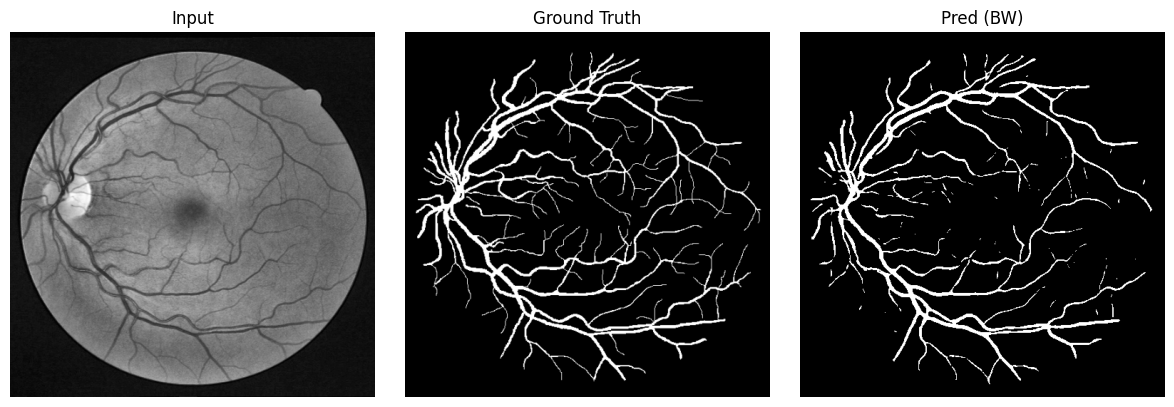

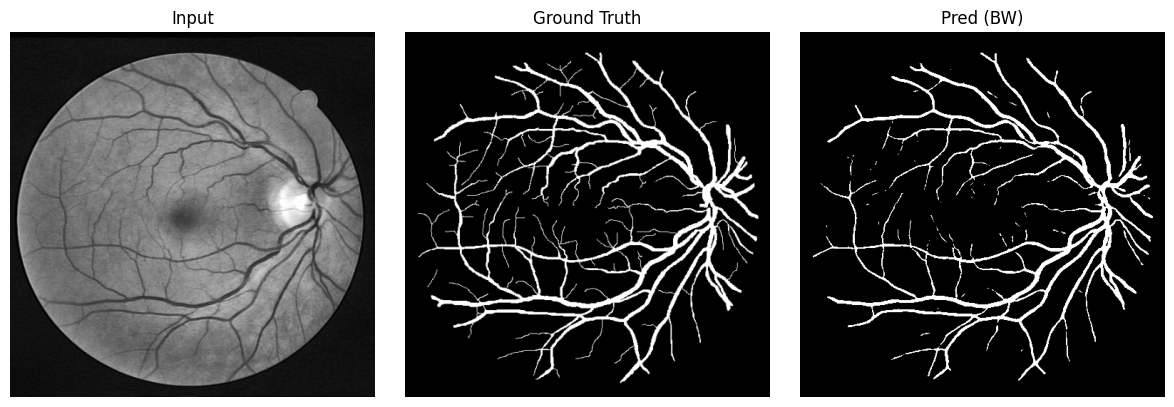

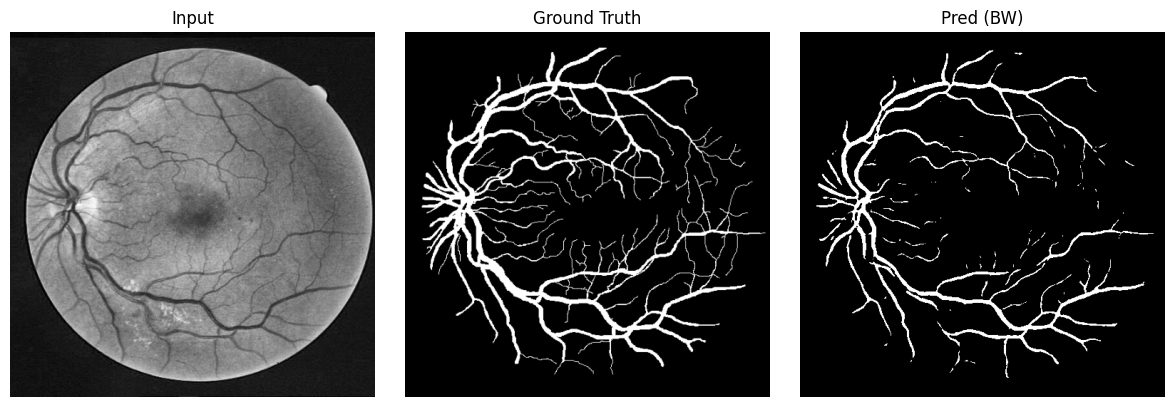

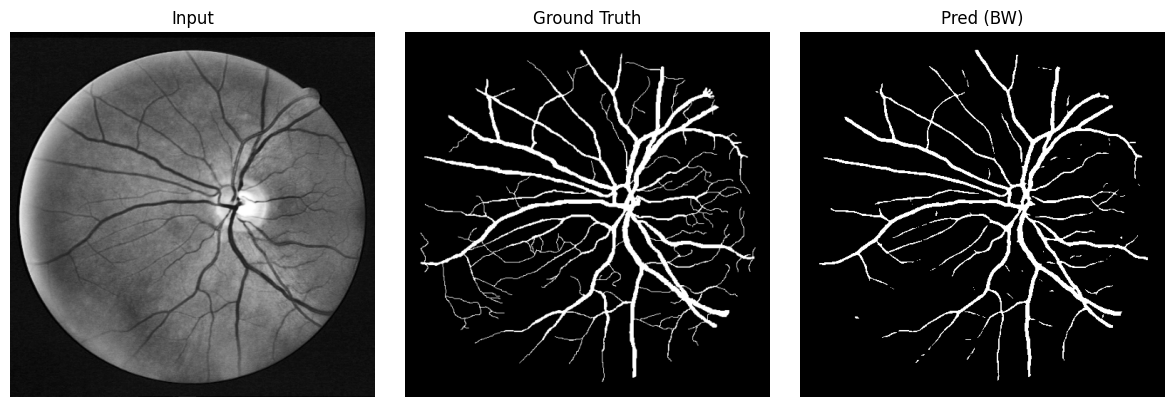

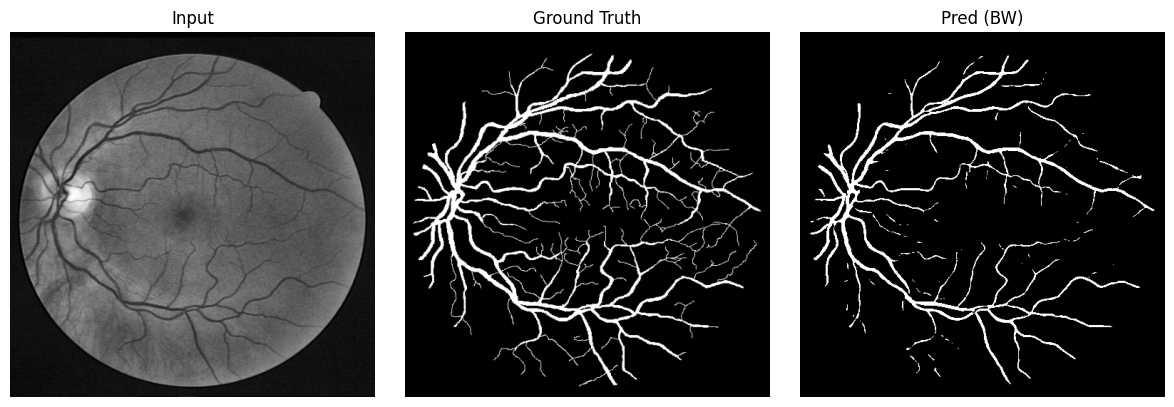

In [8]:
# -----------------------------------
# 6. Display Results (no RGB)
# -----------------------------------
import matplotlib.pyplot as plt

def display_results(i):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    # 1) Input
    axs[0].imshow(X_test[i].squeeze(), cmap='gray')
    axs[0].set_title("Input")
    axs[0].axis("off")
    # 2) Ground truth
    axs[1].imshow(y_test[i].squeeze(), cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")
    # 3) Prediction (BW)
    axs[2].imshow(preds_bin[i].squeeze(), cmap='gray')
    axs[2].set_title("Pred (BW)")
    axs[2].axis("off")
    plt.tight_layout()
    plt.show()

# Display first 5 samples
for i in range(5):
    display_results(i)


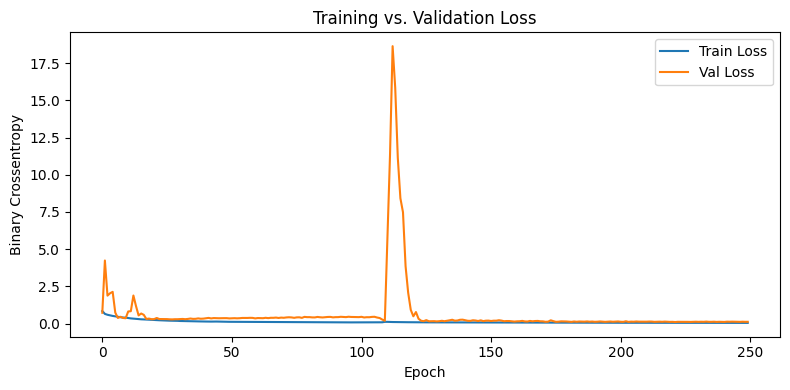

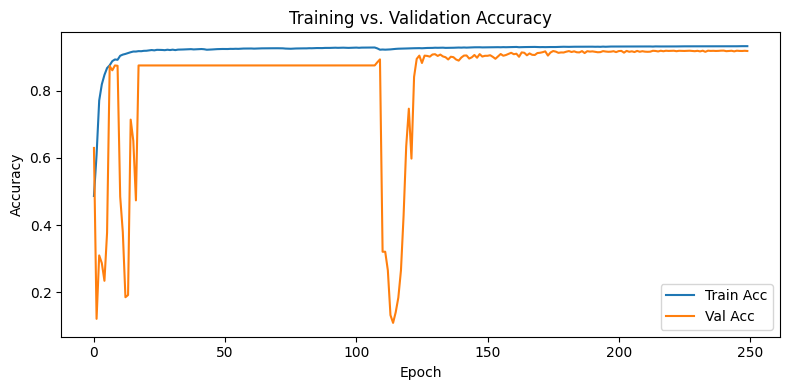

In [9]:
# -----------------------------------
# 7. Plot Training & Validation Metrics
# -----------------------------------
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],     label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.tight_layout()
plt.show()

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'],      label='Train Acc')
plt.plot(history.history['val_accuracy'],  label='Val Acc')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
